In [6]:
import os
import datetime as dt
from datetime import date
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from pprint import pprint
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor, VotingClassifier, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn import linear_model
from tqdm import tqdm
from scipy.stats import norm
import statistics
from ast import literal_eval
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import copy

# tensorflow
import tensorflow
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

pd.set_option('max_columns', 330)
pd.set_option('max_rows', 100)

In [7]:
%matplotlib inline
# plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

# Load dataframes

In [3]:
input_path = r'C:\Users\Panagiotis.Mavritsak\Desktop\Ner thesis\\'
df = pd.read_excel(input_path+'data.xlsx', index_col=0)
df = df.resample('M', label='right').mean()
df

,Aluminium (USD/tonne),Copper (USD/pound),Zinc (USD/tonne),Nickel (USD/MT),Lead (USD/tonne),Tin (USD/tonne),Silver (USD/ t oz),Gold (USD/ t oz),Crude Oil WTI (USD/ bbl),Crude oil Brent (USD/bbl),Natural gas (USD/Mmbtu),USD index,DJIA (USD),FTSE 100 (GBP),Hang seng (HKD),US libor
Date,,,,,,,,,,,,,,,,
1995-01-31,2060.365000,1.400250,1156.515000,9605.200000,665.875000,6194.750000,4.753800,378.585000,17.973500,16.553000,1.430350,88.151500,3873.884000,3030.105000,7454.471000,6.339500
1995-02-28,1893.213333,1.340267,1022.873333,8360.866667,575.740000,5420.533333,4.702267,376.926667,18.545333,17.070000,1.438600,87.368667,3959.192667,3060.286667,7989.160000,6.260667
1995-03-31,1802.627273,1.390091,1023.109091,7536.363636,584.336364,5536.590909,4.658955,382.454545,18.574545,16.916818,1.535455,83.746818,4063.885000,3079.659091,8370.944545,6.268636
1995-04-30,1851.800000,1.335882,1062.082353,7403.882353,607.876471,5866.411765,5.533294,391.105882,19.916471,18.420588,1.660941,81.663529,4234.504118,3198.858824,8501.802353,6.235882
1995-05-31,1767.871429,1.281095,1036.171429,7275.476190,596.352381,5926.714286,5.512095,385.571429,19.714286,18.388571,1.709762,82.672381,4391.934286,3288.314286,8935.610476,6.127619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,1748.559524,2.661929,2279.916667,15748.642857,2044.547619,16587.023810,17.217476,1503.085714,54.901429,59.540000,2.171619,97.999381,26065.815238,7203.483333,26001.722381,2.164805
2019-09-30,1764.162500,2.687475,2320.125000,17633.825000,2074.862500,16842.875000,18.142100,1509.445000,56.967000,62.468500,2.519550,98.594250,26900.214000,7321.854000,26516.656000,2.124800
2019-10-31,1733.214286,2.692143,2425.654762,16991.380952,2188.416667,16663.571429,17.691190,1495.980952,54.083810,59.728571,2.345462,98.082948,26756.916667,7215.755714,26458.149524,1.970481


In [4]:
df.isnull().sum()

Aluminium (USD/tonne)        0
Copper (USD/pound)           0
Zinc (USD/tonne)             0
Nickel (USD/MT)              0
Lead (USD/tonne)             0
Tin (USD/tonne)              0
Silver (USD/ t oz)           0
Gold (USD/ t oz)             0
Crude Oil WTI (USD/ bbl)     0
Crude oil Brent (USD/bbl)    0
Natural gas (USD/Mmbtu)      0
USD index                    0
DJIA (USD)                   0
 FTSE 100 (GBP)              0
Hang seng (HKD)              0
 US libor                    0
dtype: int64

### create lagged df

In [5]:
def lagged_df_func(df, target_variable, min_lag=1, max_lag=90):
    '''Create a dataframe with variables that are lagged between a minimum and maximum lag
    Arg1: datafarme produced as output of exploratory data analysis functions
    Arg2: variable for the analysis
    Arg2: minimum lag for each variable
    Arg3: Maximum lag for each variable
    Returns: Pandas dataframe with variables lagged between minimum and maximum lag
    '''
    df = df.reset_index()  # .drop(columns='index')
    feature_list = list(df.columns)
#     feature_list.remove('month')
    feature_list.remove('Date')

    lagged_df = pd.DataFrame()

    for variable in feature_list:
        for i in range(min_lag, max_lag + 1):
            col2 = df[variable].shift(i)
            lagged_df[variable + '_' + str(i)] = col2

    lagged_df['Date'] = df['Date']
#     lagged_df['month'] = df['month']
    lagged_df[target_variable] = df[target_variable]
    if target_variable+'_0' in lagged_df.columns:
        lagged_df = lagged_df.drop(columns=['malaria_prev_0'])
    lagged_df.set_index('Date', inplace=True)
    
    return(lagged_df)

# 1. Univariate analysis

First define functions

In [91]:
results_path = r'C:\Users\Panagiotis.Mavritsak\Desktop\Ner thesis\results\\'

def plot_model_performance(lagged_df, results, y_test, target_var, results_path):
    plt.figure(figsize=(20, 20))

    plt.plot(lagged_df.index, lagged_df[target_var], 'b', label='observed')
#     plt.plot(results['predicted dates'], y_test, 'b', label='observed')
    plt.plot(results['predicted dates'], results['central_prediction'], 'y', label='central prediction')
#     plt.plot(results['predicted dates'], results['upper_bound'], 'r', label='upper prediction')
#     plt.plot(results['predicted dates'], results['lower_bound'], 'r', label='lower prediction')
    conf = results['confidence_interval']
#     plt.fill_between(results['predicted dates'], results['lower_bound'], results['upper_bound'],
#                      color='r', alpha=0.05, label=f'{conf:.0f}% confidence interval')
    plt.legend()
    plt.xlabel('dates')
    plt.ylabel(target_var)
    mt = results['model_type']
    lt = results['lead_time']
    title = f'Model {mt} with lead time {lt} and confidence interval {conf:.0f}% performance'
    plt.title(title)
    plt.grid()
    plt.savefig(results_path+title)
    plt.show();

def zoomed_model_performance(results, y_test, target_var, results_path):
    # plot
    plt.figure(figsize=(12, 12))

    plt.plot(results['predicted dates'], y_test, 'b', label='observed')
    plt.plot(results['predicted dates'], results['central_prediction'], 'y', label='central prediction')
    plt.plot(results['predicted dates'], results['upper_bound'], 'r', label='upper prediction')
    plt.plot(results['predicted dates'], results['lower_bound'], 'r', label='lower prediction')
    conf = results['confidence_interval']
    plt.fill_between(results['predicted dates'], results['lower_bound'], results['upper_bound'],
                     color='r', alpha=0.05, label=f'{conf:.0f}% confidence interval')

    plt.legend()
    plt.xlabel('dates')
    plt.ylabel(target_var)
    mt = results['model_type']
    lt = results['lead_time']
    title = f'Zoomed in - Model {mt} with lead time {lt} and confidence interval {conf:.0f}% performance'
    plt.title(title)
    plt.grid()
    plt.savefig(results_path + title)
    plt.show();
    
def create_sequence_features(df, column, lead_time, L=10):
    x = []
    for i in range(L, len(df)-lead_time, 1):
        # get sequence
        x.append(df[column].iloc[i:i-L:-1].values)
    return(x)

def create_sequence_target(df, target_var, lead_time, L=10):
    x = []
    dates = []
    for i in range(L+lead_time, len(df), 1):
        # get sequence
        x.append(df[target_var].iloc[i])
        dates.append(df.index[i])
    return(x, dates)

def LSTM_univariate_model_run(df, lead_time, target_var, L, confidence=0.9, boot=1000, test_ratio=0.1):
    
    X = create_sequence_features(df, target_var, lead_time, L=L)
    y, pred_date = create_sequence_target(df, target_var, lead_time, L=L)
    
    # LSTM model
    inp = Input(shape=(L,1))
    z = LSTM(5)(inp)
#     z = LSTM(5)(z)
    z = Dense(1)(z)

    # create test dataset, if we want to test on the last values
    test_break = int(len(X) * (1 - test_ratio))
    X_train = np.asarray(X[:test_break])
    y_train = np.asarray(y[:test_break])
    X_test  = np.asarray(X[test_break:])
    y_test  = np.asarray(y[test_break:])
    pred_date = pred_date[test_break:]
#     pred_date = df.index[test_break:]  
#     pred_date = pred_date.to_numpy()

    # train model
    scalar = StandardScaler()
    scalar.fit_transform(X_train)
    scalar.transform(X_test)


    # make predictions for test data
    predictions = -9999 * np.ones((boot, len(y_test)))
    for j in range(boot):
        mod = Model(inp,z)
        mod.compile(
                    loss='mean_squared_error',
                    optimizer=Adam(lr=0.01),
                    metrics = 'mean_squared_error',
                   )

        # train
        r_LSTM = mod.fit(
                         X_train, y_train,
                         epochs=100, 
                         verbose=0
                        )

        y_pred = mod.predict(X_test)
#         print(np.shape(y_pred))
#         print(y_pred)
#         print(y_pred[0])
#         print(y_pred[:, 0])
        predictions[j, :] = y_pred[:, 0]
        
    # plot training history
    # setup plots
    f, axes = plt.subplots(1,figsize=(6,3))

    # plot training loss
    axes.plot(r_LSTM.history['loss'], label ='LSTM')
    axes.set_title('Training error')
    axes.legend()

    upper = -9999 * np.ones(len(y_test))
    mean = -9999 * np.ones(len(y_test))
    lower = -9999 * np.ones(len(y_test))

    for j in range(len(y_test)):
        pred = predictions[:, j]
        pred = np.sort(pred)

        lower[j] = pred[int(len(pred) * ((1 - confidence) / 2))]
        mean[j] = pred[int(len(pred) * 0.5)]
        upper[j] = pred[int(len(pred) * (1 - ((1 - confidence) / 2)))]


    
    # evaluate predictions
    rmse = np.sqrt(mean_squared_error(y_test, mean))
    coefficient_of_dermination = r2_score(y_test, mean)
    emse = np.mean(y_test**2 - mean**2)
    mae = np.mean(y_test - mean)
    mape = np.mean(np.abs((y_test - mean)/y_test))*100  # %
    nse = 1-(np.sum((mean-y_test)**2)/np.sum((y_test-np.mean(y_test))**2))

    results_dict = {'model_type': 'LSTM', 'lead_time': int(lead_time), 'root mean squared error': rmse,
                    'MAE':mae, 'MAPE [%]':mape, 'R2:': coefficient_of_dermination, 'expected mean squared error': emse, 
                    'NSE':nse, 'test_break': test_break, 'confidence_interval': confidence * 100, 
                    'predicted dates': pred_date, 'lower_bound': lower, 'central_prediction': mean, 'upper_bound': upper,
                    'test_ratio': test_ratio * 100}

    return(results_dict, predictions, y_test)

### 1. target variable is 'Aluminium (USD/tonne)'

DL models

In [92]:
target_var = 'Aluminium (USD/tonne)'

Use to set L

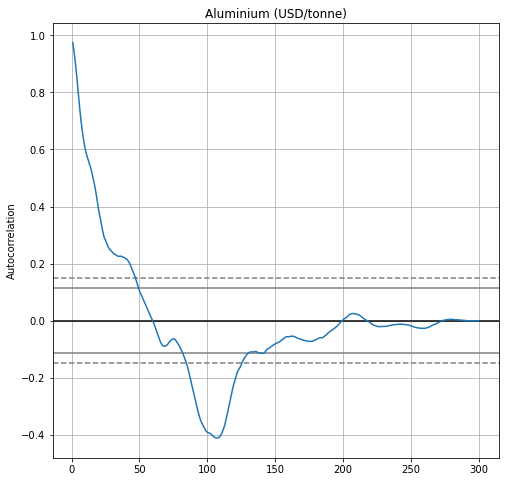

In [93]:
# define subplot grid
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pd.plotting.autocorrelation_plot(df[target_var], ax=ax)
# chart formatting
ax.set_title(target_var)
ax.set_xlabel("")
plt.show();

In [94]:
results_path = r'C:\Users\Panagiotis.Mavritsak\Desktop\Malaria\results\performance plots//'

lead_times = [1, 2, 3, 4, 5, 6, 12]

confidence_intervals = [0.95]

L = 50

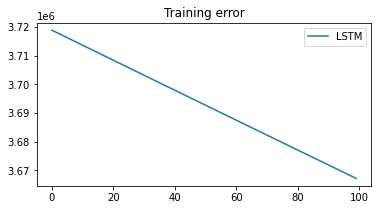

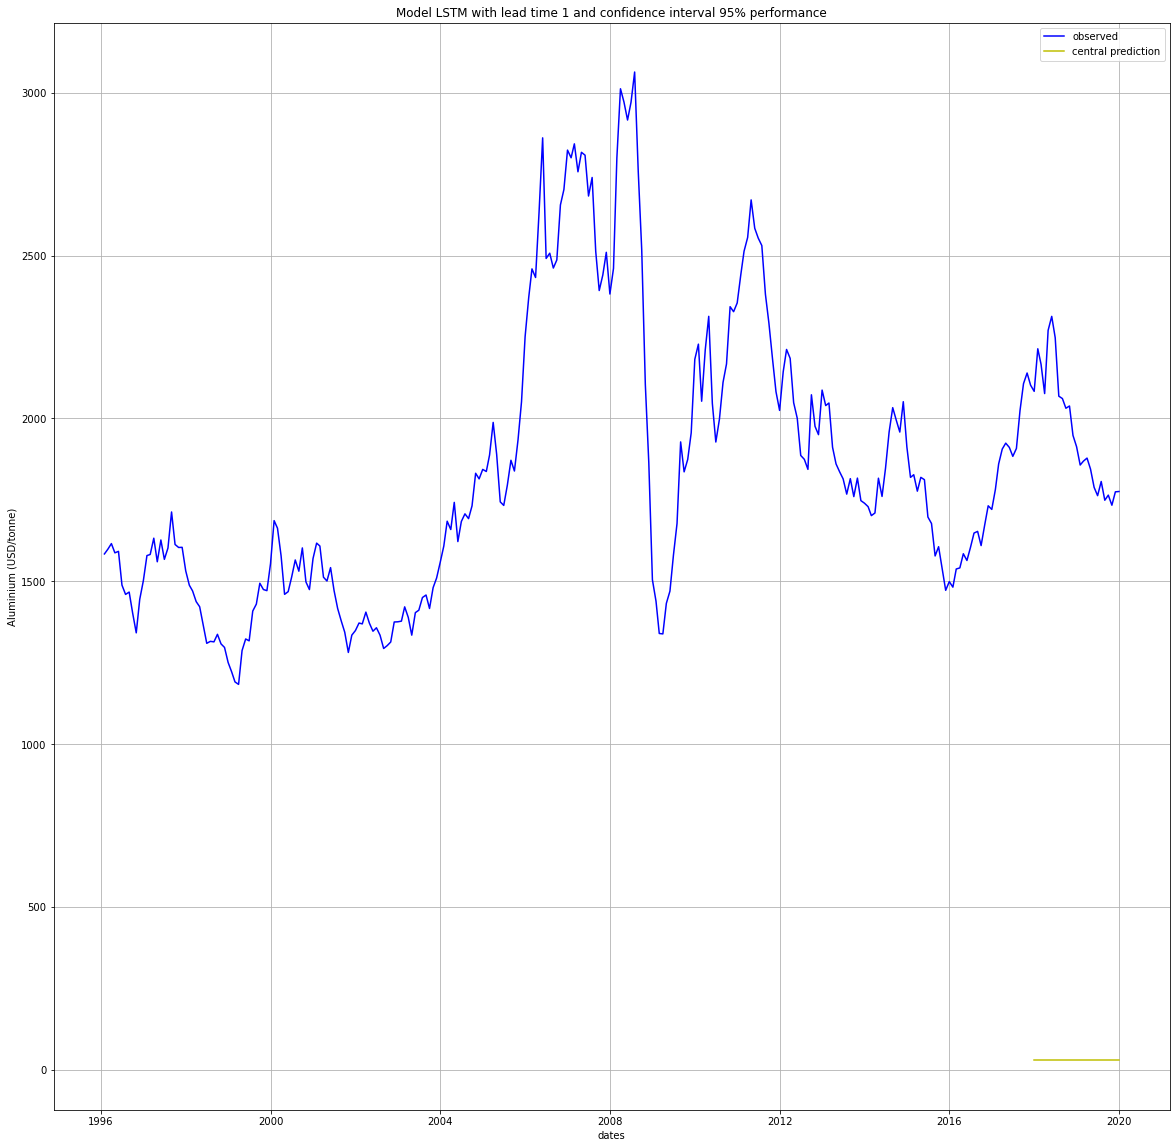

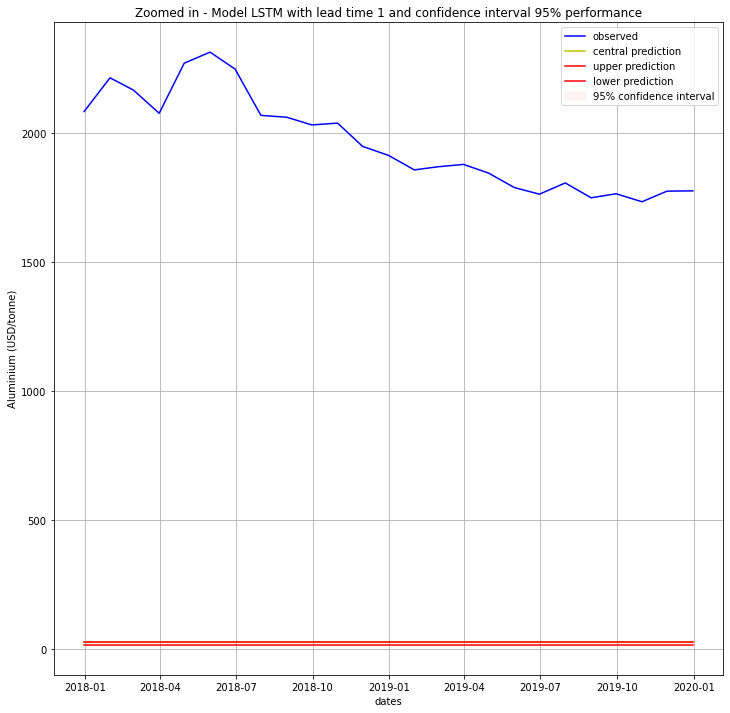

KeyboardInterrupt: 

In [95]:
predictions_df = pd.DataFrame()

for lead_time in lead_times:
    for confidence_interval in confidence_intervals:

        results, predictions, y_test = LSTM_univariate_model_run(df=df, 
                                                                 lead_time=lead_time, 
                                                                 target_var=target_var,
                                                                 L=L,
                                                                 confidence=confidence_interval,
                                                                 boot=2, 
                                                                 test_ratio=0.1
                                                                )
        # plot results
#             print(results)
        plot_model_performance(lagged_df, results, y_test, target_var, results_path)
        zoomed_model_performance(results, y_test, target_var, results_path)

        predictions_df = predictions_df.append(results, ignore_index=True)
        
predictions_df.to_excel(results_path+f'Univariate LSTM Model results ALUMINIUM - monthly resolution.xlsx', index=False)
predictions_df

### 2. target variable is 'Copper (USD/pound)'

DL models

In [ ]:
target_var = 'Copper (USD/pound)'

In [ ]:
# define subplot grid
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pd.plotting.autocorrelation_plot(df[target_var], ax=ax)
# chart formatting
ax.set_title(target_var)
ax.set_xlabel("")
plt.show();

In [ ]:
lagged_df = lagged_df_func(df, target_var, min_lag=1, max_lag=70)
lagged_df.dropna(inplace=True)
lagged_df

In [ ]:
results_path = r'C:\Users\Panagiotis.Mavritsak\Desktop\Malaria\results\performance plots//'

lead_times = [1, 2, 3, 4, 5, 6, 12]

confidence_intervals = [0.95]

L = 50

In [ ]:
predictions_df = pd.DataFrame()

for lead_time in lead_times:
    for confidence_interval in confidence_intervals:

        results, predictions, y_test = LSTM_univariate_model_run(df=df, 
                                                                 lead_time=lead_time, 
                                                                 target_var=target_var,
                                                                 L=L,
                                                                 confidence=confidence_interval,
                                                                 boot=1000, 
                                                                 test_ratio=0.1
                                                                )
        # plot results
#             print(results)
        plot_model_performance(lagged_df, results, y_test, target_var, results_path)
        zoomed_model_performance(results, y_test, target_var, results_path)

        predictions_df = predictions_df.append(results, ignore_index=True)
        
predictions_df.to_excel(results_path+f'Univariate LSTM Model results COPPER - monthly resolution.xlsx', index=False)
predictions_df

### 3. target variable is 'Zinc (USD/tonne)'

DL models

In [ ]:
target_var = 'Zinc (USD/tonne)'

In [ ]:
results_path = r'C:\Users\Panagiotis.Mavritsak\Desktop\Malaria\results\performance plots//'

lead_times = [1, 2, 3, 4, 5, 6, 12]

confidence_intervals = [0.95]

L = 50

In [ ]:
predictions_df = pd.DataFrame()

for lead_time in lead_times:
    for confidence_interval in confidence_intervals:

        results, predictions, y_test = LSTM_univariate_model_run(df=df, 
                                                                 lead_time=lead_time, 
                                                                 target_var=target_var,
                                                                 L=L,
                                                                 confidence=confidence_interval,
                                                                 boot=1000, 
                                                                 test_ratio=0.1
                                                                )
        # plot results
#             print(results)
        plot_model_performance(lagged_df, results, y_test, target_var, results_path)
        zoomed_model_performance(results, y_test, target_var, results_path)

        predictions_df = predictions_df.append(results, ignore_index=True)
        
predictions_df.to_excel(results_path+f'Univariate LSTM Model results ZINC - monthly resolution.xlsx', index=False)
predictions_df

# 2. Multi-variate modeling

In [84]:
def corr_target(df, target_variable, title, results_path):
    '''correlation of individual features with malaria_prev
    Return: sorted dataframe with all the correlations with malaria_prev
    '''

    corrmat = df.corr()
    corrmat = corrmat[target_variable]
    corrmat = corrmat.iloc[:-1]
    corrmat = corrmat.sort_values(ascending=False, key=abs)
    corrmat = pd.DataFrame(data=corrmat, columns=[target_variable])
    corrmat.reset_index(inplace=True)
    corrmat.rename({'index': 'feature'}, axis=1, inplace=True)

    corrmat.to_excel(results_path + title, index=False)

    return (corrmat)

def choose_best_vars(lagged_df, lead_times, target_variable, results_path, thr = 0.4):
    best_vars = []

    for lead_time in lead_times:
        title = f'Sorted correlations for lead time {lead_time}.xlsx'
        if lead_time==1:
            df_corr = corr_target(lagged_df, target_variable, title, results_path)
        else:
            temp_lagged_df = copy.deepcopy(lagged_df)
            temp_lagged_df[target_variable] = lagged_df[target_variable].shift(-lead_time+1)
            temp_lagged_df.dropna(inplace=True)
            df_corr = corr_target(temp_lagged_df, target_variable, title, results_path)

        df_corr = df_corr[ df_corr[target_variable] > thr ]
        bv = df_corr.feature.to_list()

        best_vars.append(bv)
    return best_vars

def LSTM_multivariate_model_run(df, lead_time, target_var, L, confidence=0.9, boot=1000, test_ratio=0.1):
    # create X in shape (rows, features, length)
    all_sequences = [] 
    for column in df.columns:
        all_sequences.append(create_sequence_features(df, column, lead_time, L=L))
    X = []
    for j in range(np.shape(all_sequences)[1]):
        s = all_sequences[0][j] / np.max(all_sequences[0])
        for i in range(1, np.shape(all_sequences)[0], 1):
            s = np.vstack((s, all_sequences[i][j] / np.max(all_sequences[i]))) # also scaling to 0-1
        X.append(s)
        
    y, pred_date = create_sequence_target(df, target_var, lead_time, L=L)

    # create test dataset, if we want to test on the last values
    test_break = int(len(X) * (1 - test_ratio))
    X_train = np.asarray(X[:test_break])
    y_train = np.asarray(y[:test_break])
    X_test  = np.asarray(X[test_break:])
    y_test  = np.asarray(y[test_break:])
    pred_date = pred_date[test_break:]
#     pred_date = df.index[test_break:]  
#     pred_date = pred_date.to_numpy()

    # make predictions for test data
    predictions = -9999 * np.ones((boot, len(y_test)))
    for j in range(boot):
        # LSTM model
        inp = Input(shape=(np.shape(X)[1], L))  # , 1))
        z = LSTM(5)(inp)
    #     z = LSTM(5)(z)
        z = Dense(1)(z)
        mod = Model(inp,z)
        mod.compile(
                    loss='mean_squared_error',
                    optimizer=Adam(lr=0.01),
                    metrics = 'mean_squared_error',
                   )

        # train
        r_LSTM = mod.fit(
                         X_train, y_train,
                         epochs=1000, 
                         verbose=0
                        )

        y_pred = mod.predict(X_test)
        predictions[j, :] = y_pred[:, 0]
        
    # plot training history
    # setup plots
    f, axes = plt.subplots(1,figsize=(6,3))

    # plot training loss
    axes.plot(r_LSTM.history['loss'], label ='LSTM loss')
    axes.set_title('Training error')
    axes.legend()

    upper = -9999 * np.ones(len(y_test))
    mean = -9999 * np.ones(len(y_test))
    lower = -9999 * np.ones(len(y_test))

    for j in range(len(y_test)):
        pred = predictions[:, j]
        pred = np.sort(pred)

        lower[j] = pred[int(len(pred) * ((1 - confidence) / 2))]
        mean[j] = pred[int(len(pred) * 0.5)]
        upper[j] = pred[int(len(pred) * (1 - ((1 - confidence) / 2)))]


    
    # evaluate predictions
    rmse = np.sqrt(mean_squared_error(y_test, mean))
    coefficient_of_dermination = r2_score(y_test, mean)
    emse = np.mean(y_test**2 - mean**2)
    mae = np.mean(y_test - mean)
    mape = np.mean(np.abs((y_test - mean)/y_test))*100  # %
    nse = 1-(np.sum((mean-y_test)**2)/np.sum((y_test-np.mean(y_test))**2))

    results_dict = {'model_type': 'LSTM', 'lead_time': int(lead_time), 'root mean squared error': rmse,
                    'MAE':mae, 'MAPE [%]':mape, 'R2:': coefficient_of_dermination, 'expected mean squared error': emse, 
                    'NSE':nse, 'test_break': test_break, 'confidence_interval': confidence * 100, 
                    'predicted dates': pred_date, 'lower_bound': lower, 'central_prediction': mean, 'upper_bound': upper,
                    'test_ratio': test_ratio * 100}

    return(results_dict, predictions, y_test)

### 1. target variable is 'Aluminium (USD/tonne)'

DL models

In [51]:
target_var = 'Aluminium (USD/tonne)'

Use to set L

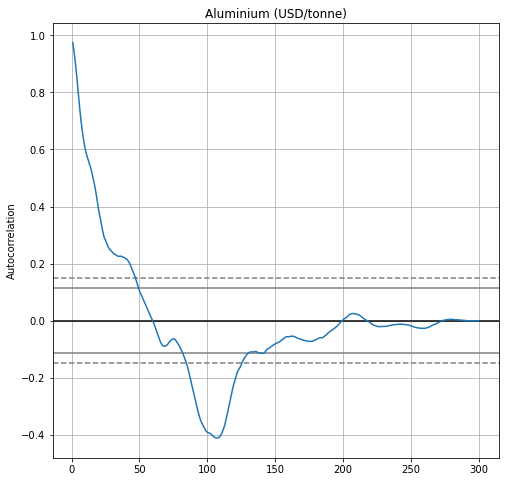

In [52]:
# define subplot grid
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pd.plotting.autocorrelation_plot(df[target_var], ax=ax)
# chart formatting
ax.set_title(target_var)
ax.set_xlabel("")
plt.show();

In [57]:
results_path = r'C:\Users\Panagiotis.Mavritsak\Desktop\Malaria\results\performance plots//'

lead_times = [1, 2, 3, 4, 5, 6, 12]

confidence_intervals = [0.95]

L = 20

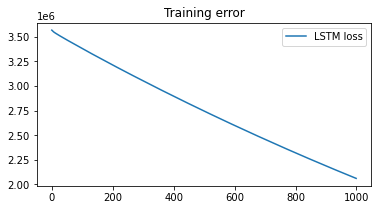

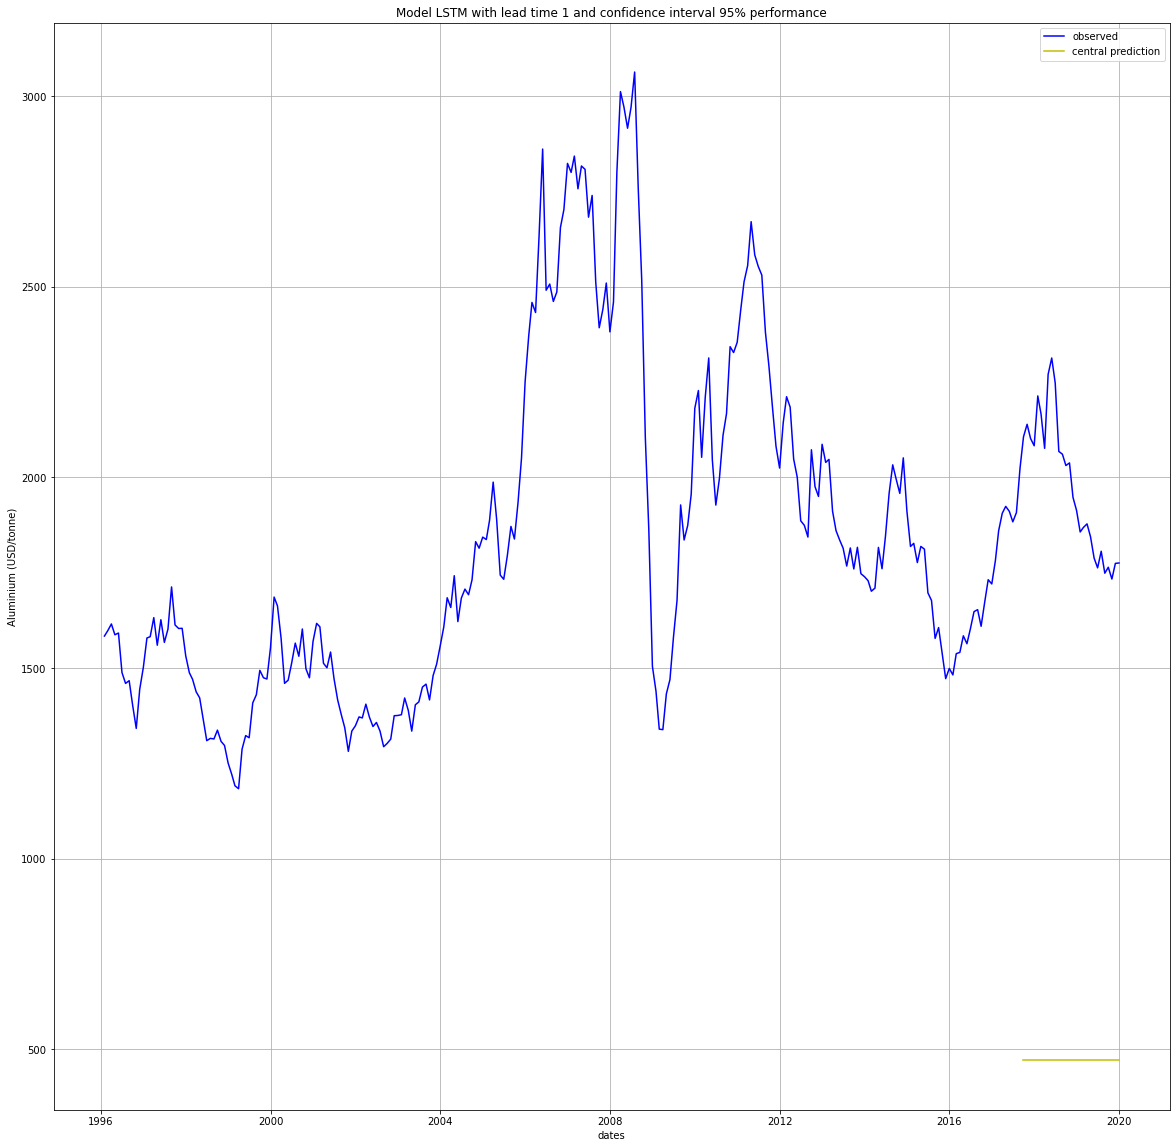

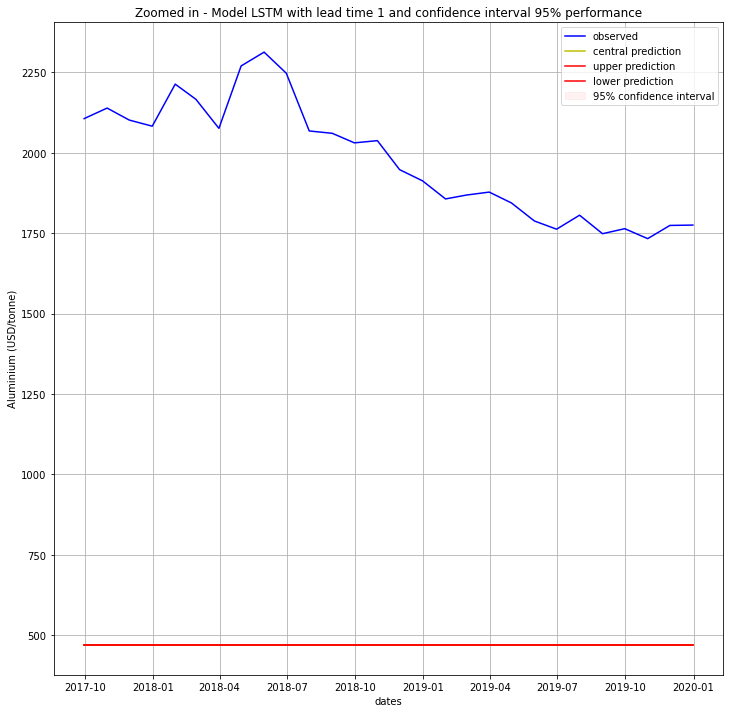

KeyboardInterrupt: 

In [85]:
predictions_df = pd.DataFrame()

for lead_time in lead_times:
    for confidence_interval in confidence_intervals:

        results, predictions, y_test = LSTM_multivariate_model_run(df=df, 
                                                                 lead_time=lead_time, 
                                                                 target_var=target_var,
                                                                 L=L,
                                                                 confidence=confidence_interval,
                                                                 boot=1000, 
                                                                 test_ratio=0.1
                                                                )
        # plot results
#             print(results)
        plot_model_performance(lagged_df, results, y_test, target_var, results_path)
        zoomed_model_performance(results, y_test, target_var, results_path)

        predictions_df = predictions_df.append(results, ignore_index=True)
        
predictions_df.to_excel(results_path+f'Univariate LSTM Model results ALUMINIUM - monthly resolution.xlsx', index=False)
predictions_df

### 2. target variable is 'Copper (USD/pound)'

DL models

In [ ]:
target_var = 'Copper (USD/pound)'

In [ ]:
# define subplot grid
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pd.plotting.autocorrelation_plot(df[target_var], ax=ax)
# chart formatting
ax.set_title(target_var)
ax.set_xlabel("")
plt.show();

In [ ]:
lagged_df = lagged_df_func(df, target_var, min_lag=1, max_lag=70)
lagged_df.dropna(inplace=True)
lagged_df

In [ ]:
results_path = r'C:\Users\Panagiotis.Mavritsak\Desktop\Malaria\results\performance plots//'

lead_times = [1, 2, 3, 4, 5, 6, 12]

confidence_intervals = [0.95]

L = 20

In [ ]:
predictions_df = pd.DataFrame()

for lead_time in lead_times:
    for confidence_interval in confidence_intervals:

        results, predictions, y_test = LSTM_multivariate_model_run(df=df, 
                                                                 lead_time=lead_time, 
                                                                 target_var=target_var,
                                                                 L=L,
                                                                 confidence=confidence_interval,
                                                                 boot=1000, 
                                                                 test_ratio=0.1
                                                                )
        # plot results
#             print(results)
        plot_model_performance(lagged_df, results, y_test, target_var, results_path)
        zoomed_model_performance(results, y_test, target_var, results_path)

        predictions_df = predictions_df.append(results, ignore_index=True)
        
predictions_df.to_excel(results_path+f'Univariate LSTM Model results COPPER - monthly resolution.xlsx', index=False)
predictions_df

### 3. target variable is 'Zinc (USD/tonne)'

DL models

In [ ]:
target_var = 'Zinc (USD/tonne)'

In [ ]:
results_path = r'C:\Users\Panagiotis.Mavritsak\Desktop\Malaria\results\performance plots//'

lead_times = [1, 2, 3, 4, 5, 6, 12]

confidence_intervals = [0.95]

L = 20

In [ ]:
predictions_df = pd.DataFrame()

for lead_time in lead_times:
    for confidence_interval in confidence_intervals:

        results, predictions, y_test = LSTM_multivariate_model_run(df=df, 
                                                                 lead_time=lead_time, 
                                                                 target_var=target_var,
                                                                 L=L,
                                                                 confidence=confidence_interval,
                                                                 boot=1000, 
                                                                 test_ratio=0.1
                                                                )
        # plot results
#             print(results)
        plot_model_performance(lagged_df, results, y_test, target_var, results_path)
        zoomed_model_performance(results, y_test, target_var, results_path)

        predictions_df = predictions_df.append(results, ignore_index=True)
        
predictions_df.to_excel(results_path+f'Univariate LSTM Model results ZINC - monthly resolution.xlsx', index=False)
predictions_df